<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/keras_applications_transfer_learning_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Summary
Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning. In this example, we are going to see how to use them for transfer learning.









# Download the dataset from Kaggle

We will download a dataset from [Kaggle](https://www.kaggle.com/).
A detail information about how to install kaggle API, configure it and check that it works can be seen in the notebook "[set_up_kaggle_api_in_colab.ipynb](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/set_up_kaggle_api_in_colab.ipynb)" in the [course repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course).

In [1]:
# Install kaggle API
! pip install kaggle
# Force install the latest version
! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=695423e24388c8dc66f501806ae904934733c73e61158fb429d92b67c24410e4
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
# Upload 'kaggle.json' file to Colab
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Move the uploaded file to a location ~/.kaggle/kaggle.json. 
# Additionally, you need to give proper permissions to the file (since this is a hidden folder). 
# Finally delete the kaggle.json file from the initial location
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! rm kaggle.json

In [4]:
# Checking that it works (optional). For example, run the following command:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        115           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        223           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        708           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3811           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      30608            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       7995           False  
connectx

For this example, we are going to download the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html) from [Kaggle](https://www.kaggle.com/miljan/stanford-dogs-dataset-traintest). The dataset that we are going to download contains two folders: one for training and one for testing, and it is a modified version of Jessica Li's dataset, which can be seen [here](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset).

In [5]:
# https://www.kaggle.com/miljan/stanford-dogs-dataset-traintest
!kaggle datasets download -d miljan/stanford-dogs-dataset-traintest

 95% 374M/393M [00:01<00:00, 275MB/s]
100% 393M/393M [00:01<00:00, 250MB/s]


We can include `%%capture` magic command to suppress the output.

In [6]:
%%capture

# Unzip the dataset:
!unzip /content/stanford-dogs-dataset-traintest.zip

You'll find here a training folder with 120 folders corresponding to the 120 breeds of dogs from around the world. The testing folder is organized in the same way. We set the path where the images (for both training and testing) have been extracted:

In [7]:
# Path of the both train and test directories
train_dir='/content/cropped/train'
test_dir='/content/cropped/test'

We can show both the version of TensorFlow and Keras.

In [8]:
import tensorflow as tf

# Examine software versions:
print(tf.__version__)         # 2.4.1
print(tf.keras.__version__)   # 2.4.0

2.4.1
2.4.0


# Introduction to EfficientNet

Compared to other models achieving similar ImageNet accuracy, [EfficientNet](https://keras.io/api/applications/efficientnet/) models are much smaller. For example, the [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function) model as you can see in [Keras application](https://keras.io/api/applications/) has `25,636,712` parameters in total (weights are `98 MB`), and even though, it still underperforms the smallest EfficientNet ([EfficientNetB0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function)), which only takes `5,330,571` parameters in total (weights are `29 MB`). The [EfficientNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) default weights contains 1000 class labels (pre-trained on ImageNet) and they can be excluded while loading the model by specifying the `include_top` argument to `False`.

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |


In [9]:
# Change the resolution of the input shape according to the selected base model:
INPUT_SHAPE = (224, 224)

In [10]:
from tensorflow.keras.applications import EfficientNetB0

base_model_eff = EfficientNetB0(include_top=False, input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3), weights="imagenet")

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model_eff.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

As we can see (in case of EfficientNetB0, for example) the output is a `4D` tensor with a shape of `(batch_size, 7, 7, 1280)`. In a similar fashion that we performed in the notebook "[keras_applications_feature_extraction_for_classification.ipynb](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/keras_applications_feature_extraction_for_classification.ipynb)", we can also add a [GlobalMaxPooling2D](https://keras.io/api/layers/pooling_layers/global_max_pooling2d/) layer. 

In [11]:
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras import models
from tensorflow.keras import layers

base_model_eff = EfficientNetB0(include_top=False, input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3), weights="imagenet")
model = models.Sequential()
model.add(base_model_eff)
model.add(layers.GlobalMaxPooling2D())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


[`GlobalMaxPooling2D()`](https://keras.io/api/layers/pooling_layers/global_max_pooling2d/) accepts as input a `4D` tensor with shape `(batch_size, rows, cols, channels)`. It operates the max on the `rows` and `cols` dimensionalities for all the `channels`. The resulting dimensionality is `2D` (`batch_size`, `channels`). Hence, and as we can see the output is a `2D` tensor with shape `(batch_size, 2048)`. In summary, `GlobalMaxPooling2D()` results in a much smaller number of features compared to the `Flatten() `layer, which effectively reduces the number of parameters.  


# Exploring the dataset

We are going to declare both a `ImageDataGenerator()` for training (`train_datagen`) and another for testing (`test_datagen`).

In [12]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,  
    rotation_range = 5,
    horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [13]:
BATCH_SIZE = 32

In [14]:
train_generator=train_datagen.flow_from_directory(train_dir,
                                            class_mode="categorical", 
                                            target_size=INPUT_SHAPE, 
                                            batch_size=BATCH_SIZE)

validation_generator=test_datagen.flow_from_directory(test_dir,
                                            class_mode="categorical", 
                                            target_size=INPUT_SHAPE, 
                                            batch_size=BATCH_SIZE)

Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


As we can see, there are 12000 belonging to 120 classes, which are going to be used for training, and there are 8580 images belonging to the same number of classes, which are going to be used for testing. At this point, we can get the mapping of the classes to indexes created by the generator. Therefore, `label_map` variable will be a dictionary where each key will be the name of the breed of dogs (e.g. 'n02085620-Chihuahua') and the value will be the corresponding index:

In [15]:
# Get the mapping of classes to indexes created by the generator: {generator.class_indices}
label_map = train_generator.class_indices
print(label_map)

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

We are going to create function `get_key()`, which is going to be used later, and it is going to help us returning the key from a value in a dictionary.

In [16]:
# This function is used to return the key from a value in the dictionary
# To do it, we iterate over all items in the dictionary
# and if the value is the same, we return its corresponding key
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key 
    return "key doesn't exist"

In [17]:
# We test this function with the 'label_map' created before
print(get_key(label_map, 0))
print(get_key(label_map, -1))

n02085620-Chihuahua
key doesn't exist


In [18]:
# Other option to get the class name is to 'invert' the train_generator.class_indices dictionary:
inverted_label_map = {v: k for k, v in train_generator.class_indices.items()} 
print(inverted_label_map)

{0: 'n02085620-Chihuahua', 1: 'n02085782-Japanese_spaniel', 2: 'n02085936-Maltese_dog', 3: 'n02086079-Pekinese', 4: 'n02086240-Shih-Tzu', 5: 'n02086646-Blenheim_spaniel', 6: 'n02086910-papillon', 7: 'n02087046-toy_terrier', 8: 'n02087394-Rhodesian_ridgeback', 9: 'n02088094-Afghan_hound', 10: 'n02088238-basset', 11: 'n02088364-beagle', 12: 'n02088466-bloodhound', 13: 'n02088632-bluetick', 14: 'n02089078-black-and-tan_coonhound', 15: 'n02089867-Walker_hound', 16: 'n02089973-English_foxhound', 17: 'n02090379-redbone', 18: 'n02090622-borzoi', 19: 'n02090721-Irish_wolfhound', 20: 'n02091032-Italian_greyhound', 21: 'n02091134-whippet', 22: 'n02091244-Ibizan_hound', 23: 'n02091467-Norwegian_elkhound', 24: 'n02091635-otterhound', 25: 'n02091831-Saluki', 26: 'n02092002-Scottish_deerhound', 27: 'n02092339-Weimaraner', 28: 'n02093256-Staffordshire_bullterrier', 29: 'n02093428-American_Staffordshire_terrier', 30: 'n02093647-Bedlington_terrier', 31: 'n02093754-Border_terrier', 32: 'n02093859-Kerry_

At this point, we can see how the images look like. In this sense, we are going to plot a batch of images.

In [20]:
# When you call the next() function, your data generator loads your first batch. 
# The result should contain both train data and train label. You can access them by index.
image_batch, label_batch = next(train_generator)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,20))
    for n in range(32):
        ax = plt.subplot(8,4,n+1)
        plt.imshow(image_batch[n])        

        # Get the index of the label (label is one-hot encoded)
        val = np.argmax(label_batch[n])

        # Get the label with 'method 1'        
        label = get_key(label_map, val)
        # print(label)

        # Get the label with 'method 2'
        label = inverted_label_map[val]
        # print(label)

        plt.title(label)

        plt.axis('off')

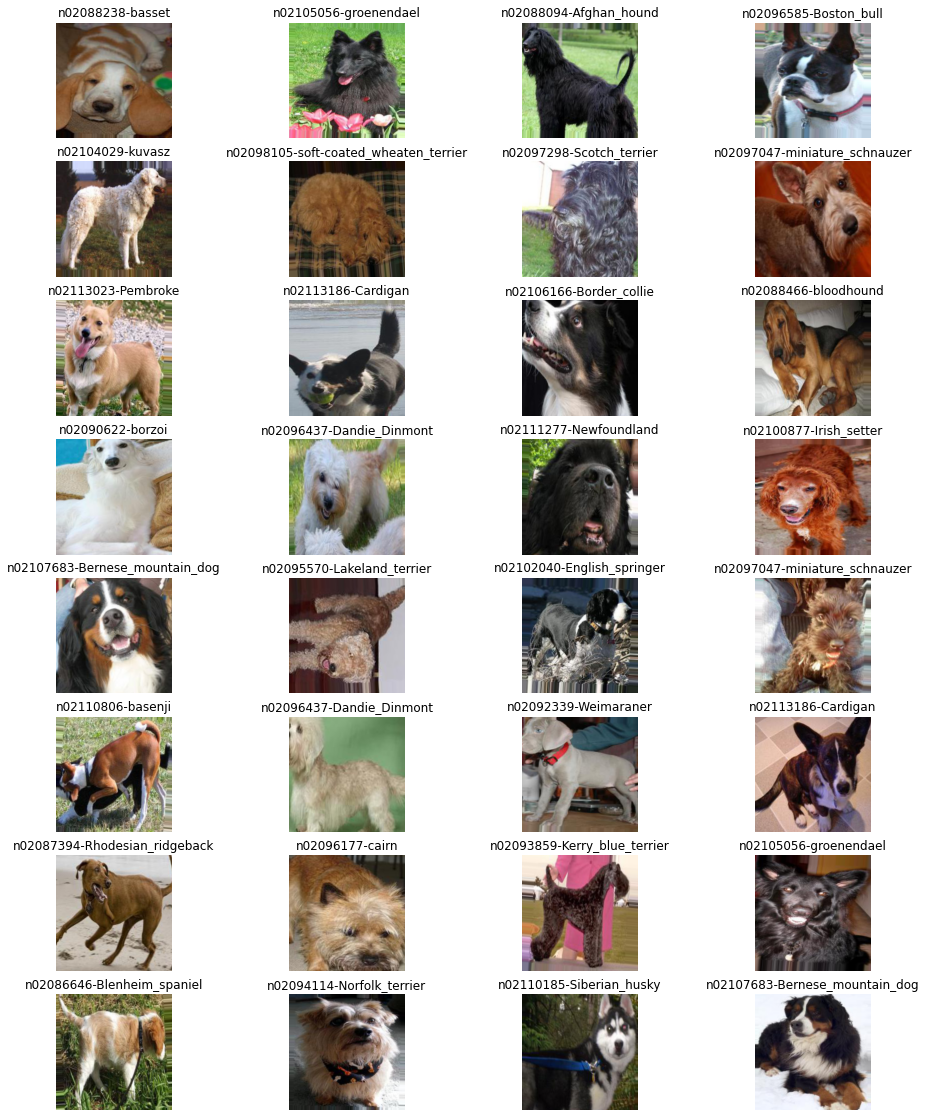

In [22]:
show_batch(image_batch, label_batch)

Once we verify the input data and augmentation are working correctly, we can start defining the model.

# Defining the model and training

At this point, we can define the model. Here we initialize the model with pre-trained ImageNet weights. The first step to transfer learning is to freeze all layers and train only the top layers. For this step, a relatively large learning rate (1e-2) can be used. Note that validation accuracy and loss will usually be better than training accuracy and loss. This is because the regularization is strong, which only suppresses training-time metrics.

In [23]:
# Get the number of classes:
NUM_CLASSES = len(train_generator.class_indices)
print(NUM_CLASSES)

120


In [25]:
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import BatchNormalization
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

def build_model(num_classes, drop_connect_rate=0.2, dropout_rate=0.2):
  base_model_eff = EfficientNetB0(include_top=False, 
                                     input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3), 
                                     weights="imagenet",
                                     drop_connect_rate=drop_connect_rate
                                  )

  # Freeze the pretrained weights
  # base_model_eff.trainable = False

  # fix the feature extraction part of the model
  for layer in base_model_eff.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False  

  # Create a Sequential model:
  model = models.Sequential()
  model.add(base_model_eff)

  # Rebuild top:
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.BatchNormalization())

  if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate))
  
  model.add(layers.Dense(num_classes, activation="softmax"))

  # Compile:  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  return model

In [27]:
model = build_model(num_classes=NUM_CLASSES, drop_connect_rate=0.4, dropout_rate=0.4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
Total params: 4,208,411
Trainable params: 198,296
Non-trainable params: 4,010,115
_________________________________________________________________


At this point, we can train the model. Note that the convergence may take up to 50 epochs depending on choice of learning rate. 

In [28]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
375/375 [==============================] - 216s 472ms/step - loss: 4.2108 - accuracy: 0.1516 - val_loss: 5.3327 - val_accuracy: 0.0118
Epoch 2/10
375/375 [==============================] - 174s 464ms/step - loss: 1.6367 - accuracy: 0.5436 - val_loss: 1.2821 - val_accuracy: 0.6287
Epoch 3/10
375/375 [==============================] - 173s 462ms/step - loss: 1.1593 - accuracy: 0.6668 - val_loss: 0.7948 - val_accuracy: 0.7593
Epoch 4/10
375/375 [==============================] - 173s 461ms/step - loss: 0.9651 - accuracy: 0.7074 - val_loss: 0.7410 - val_accuracy: 0.7775
Epoch 5/10
375/375 [==============================] - 172s 459ms/step - loss: 0.8687 - accuracy: 0.7338 - val_loss: 0.7259 - val_accuracy: 0.7826
Epoch 6/10
375/375 [==============================] - 172s 458ms/step - loss: 0.7706 - accuracy: 0.7645 - val_loss: 0.7822 - val_accuracy: 0.7797
Epoch 7/10
375/375 [==============================] - 173s 461ms/step - loss: 0.7142 - accuracy: 0.7761 - val_loss: 0.7055 -

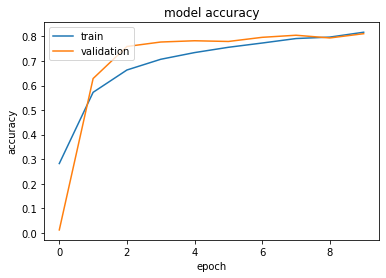

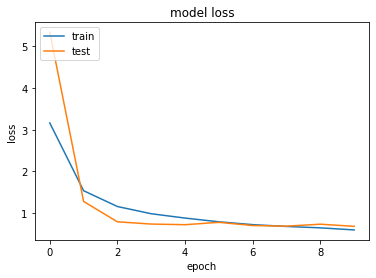

In [29]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    # Plot accuracy
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_hist(history)

The second step is to unfreeze a number of layers and fit the model using smaller learning rate. When the feature extraction with pretrained model works good enough, this step would give a very limited gain on validation accuracy. In our case, we only see a small improvement, as ImageNet pretraining already exposed the model to a good amount of dogs. On the other hand, when we use pretrained weights on a dataset that is more different from ImageNet, this fine-tuning step can be crucial as the feature extractor also needs to be adjusted by a considerable amount. As this step in for this specific case does not improve the obtained results, it can be omited. However, it is always a good point to consider.

# Saving the trained model

We can save the trained model on disk. Moreover, we also download the model.

In [30]:
# Save the weights:
model.save('eff_b0_dogs_classification.h5')

In [31]:
# Download the model:
from google.colab import files

files.download('eff_b0_dogs_classification.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Using the model for prediction

In order to use the model for prediction, we can perform the following:

In [32]:
from tensorflow.keras.preprocessing import image

img_path = "/content/cropped/test/n02085620-Chihuahua/n02085620_10074.jpg"

# Change the resolution of the input shape according to the selected base model:
INPUT_SHAPE = (224, 224)

# Read the image and resize it
img = image.load_img(img_path, target_size=INPUT_SHAPE)

# Convert it to a Numpy array with target shape.
x = image.img_to_array(img)
print(x.shape)

# Reshape:
x = x.reshape((1,) + x.shape)
x /= 255.
print(x.shape)

result = model.predict([x])
index = np.argmax(result, axis=1)[0]

print(get_key(label_map, index))

(224, 224, 3)
(1, 224, 224, 3)
n02085620-Chihuahua


# Loading a trained model

We are going to download the trained model from our repository and using it for prediction.

In [33]:
!wget https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/dogs_classification/eff_b0_dogs_classification.h5 -O my_model.h5

--2021-04-12 12:44:34--  https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/dogs_classification/eff_b0_dogs_classification.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19031848 (18M) [application/octet-stream]
Saving to: ‘my_model.h5’

my_model.h5         100%[===================>]  18.15M  --.-KB/s    in 0.09s   

2021-04-12 12:44:35 (203 MB/s) - ‘my_model.h5’ saved [19031848/19031848]



We can load the model using `tf.keras.models.load_model()`:

In [48]:
my_model = tf.keras.models.load_model("my_model.h5")

In [49]:
from tensorflow.keras.preprocessing import image

img_path = "/content/cropped/test/n02085782-Japanese_spaniel/n02085782_1039.jpg"

# Change the resolution of the input shape according to the selected base model:
INPUT_SHAPE = (224, 224)

# Read the image and resize it
img = image.load_img(img_path, target_size=INPUT_SHAPE)

# Convert it to a Numpy array with target shape.
x = image.img_to_array(img)
print(x.shape)

# Reshape:
x = x.reshape((1,) + x.shape)
x /= 255.
print(x.shape)

result = my_model.predict([x])
index = np.argmax(result, axis=1)[0]

print(get_key(label_map, index))

(224, 224, 3)
(1, 224, 224, 3)
n02085782-Japanese_spaniel


# Fine tuning EfficientNet

As commented before, the second step is to unfreeze a number of layers and fit the model using smaller learning rate. 

In [50]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [51]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
375/375 [==============================] - 174s 464ms/step - loss: 0.4131 - accuracy: 0.8680 - val_loss: 0.7196 - val_accuracy: 0.8152
Epoch 2/10
375/375 [==============================] - 173s 460ms/step - loss: 0.4287 - accuracy: 0.8622 - val_loss: 0.7785 - val_accuracy: 0.8031
Epoch 3/10
375/375 [==============================] - 173s 462ms/step - loss: 0.4185 - accuracy: 0.8638 - val_loss: 0.8634 - val_accuracy: 0.7893
Epoch 4/10
375/375 [==============================] - 173s 461ms/step - loss: 0.4035 - accuracy: 0.8728 - val_loss: 0.8183 - val_accuracy: 0.8013
Epoch 5/10
375/375 [==============================] - 173s 460ms/step - loss: 0.3956 - accuracy: 0.8684 - val_loss: 0.8529 - val_accuracy: 0.7958
Epoch 6/10
375/375 [==============================] - 173s 460ms/step - loss: 0.3836 - accuracy: 0.8741 - val_loss: 0.7691 - val_accuracy: 0.8131
Epoch 7/10
375/375 [==============================] - 173s 462ms/step - loss: 0.3850 - accuracy: 0.8798 - val_loss: 0.7944 -

# Summary

In this notebook, we have seen how to perform image classification via fine-tuning with EfficientNet. 

It is recommended [to check this notebook](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=4RuvuIKTGDW-), which uses EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification and includes: a) training a model from scratch, transfer learning from pre-trained weights, and also c) some tips for fine tuning EfficientNet. Note that we have also a [copy of this notebook in our repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/image_classification_efficientnet_fine_tuning.ipynb).

